In [3]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
import heartpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
fs = 128.0  # Sample frequency (Hz)
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

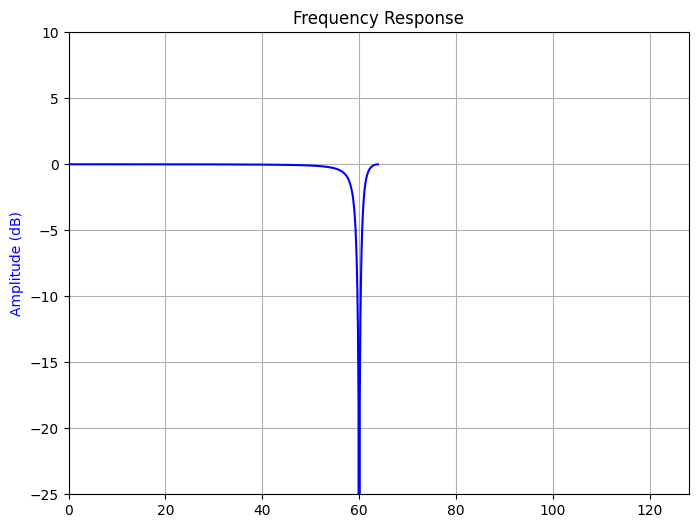

In [10]:
# Frequency response
freq, h = signal.freqz(b, a, fs=fs)
# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.plot(freq, 20*np.log10(abs(h)), color='blue')
ax.set_title("Frequency Response")
ax.set_ylabel("Amplitude (dB)", color='blue')
ax.set_xlim([0, 128])
ax.set_ylim([-25, 10])
ax.grid(True)

In [22]:
import os

data_path = os.path.join("data", "Lviv-Biometric-Data-Set")
data_dirs = os.listdir(data_path)
data_dirs.remove("LICENSE")
data_dirs.remove("README.md")
print(len(data_dirs), "users = ", data_dirs)

USERID = 1
user_path = os.path.join(data_path, "user" + str(USERID))

user_ecg = os.listdir(user_path)
print("\nuser" + str(USERID), "has", len(user_ecg), "ecg samples =", user_ecg)

18 users =  ['user1', 'user10', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16', 'user17', 'user18', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9']

user1 has 7 ecg samples = ['user1_02_26_16_42.npy', 'user1_02_29_18_37.npy', 'user1_02_29_18_38.npy', 'user1_03_09_18_16.npy', 'user1_03_10_11_14.npy', 'user1_03_10_15_09.npy', 'user1_03_10_15_10.npy']


In [23]:
SAMPLEID = 0
data = np.load(os.path.join(user_path, user_ecg[SAMPLEID]))
print(type(data))
print(data)
print(data.shape)

<class 'numpy.ndarray'>
[6038. 6046. 6446. ... 7337. 7206. 6917.]
(3000,)


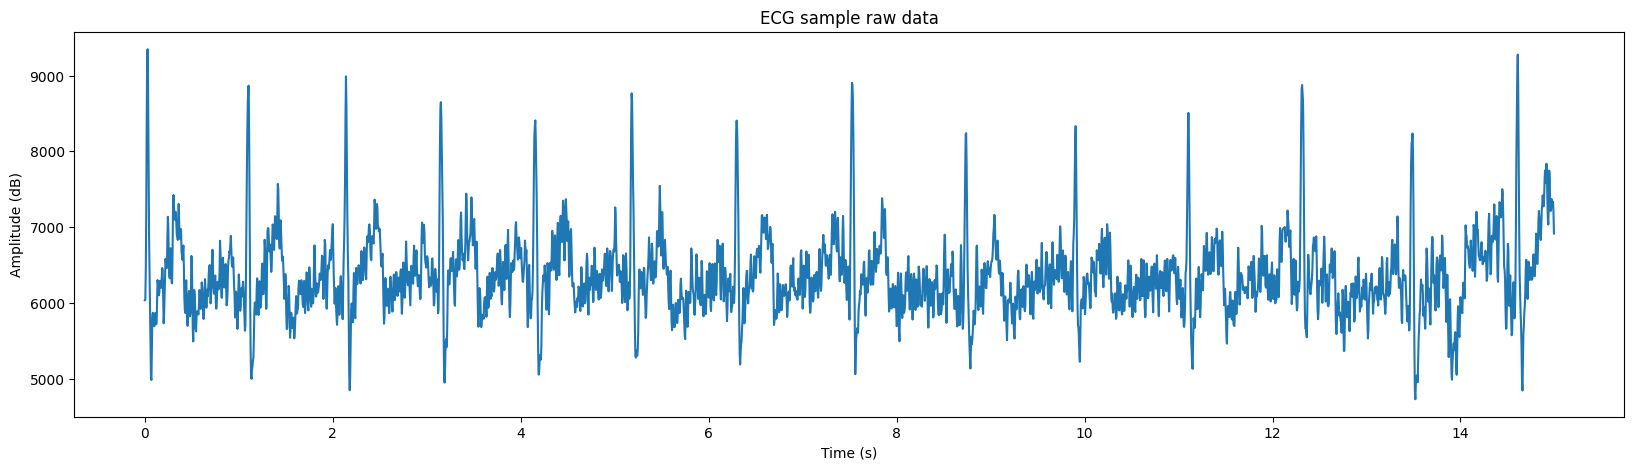

In [28]:
plt.figure(figsize=(20, 5))
plt.ylabel("Amplitude (dB)")
fs = 200
# Calculate time values in seconds
times = np.arange(data.shape[0], dtype='float') / fs
plt.plot(times, data)
plt.xlabel("Time (s)")
plt.title("ECG sample raw data")
plt.savefig('raw.png')
plt.show()

In [18]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,
                data)  # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
    return y


def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi * data[0])
    return sos, z, zi


def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi * z[0])
    return z2


def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,
                    data)  # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    return y

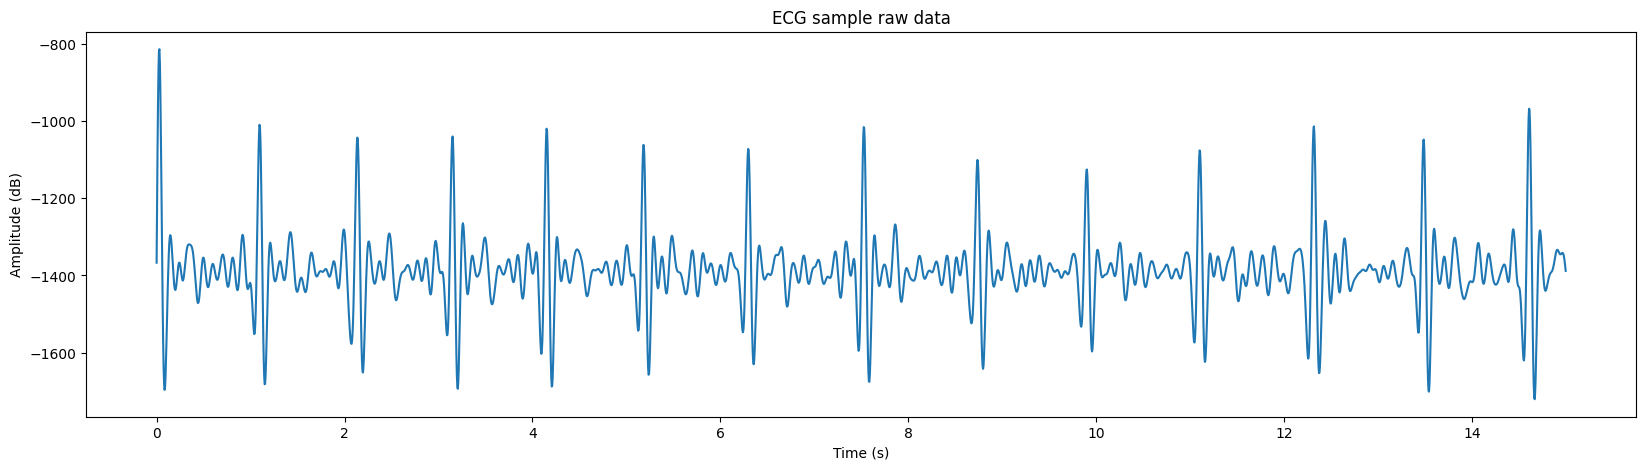

In [38]:
plt.figure(figsize=(20, 5))
plt.ylabel("Amplitude (dB)")
filtered = butter_bandpass_forward_backward_filter(data, 0.05, 10, 200, order=4)
filtered = hp.remove_baseline_wander(filtered, 200)
# Calculate time values in seconds
times = np.arange(data.shape[0], dtype='float') / fs
plt.plot(times, filtered)
plt.xlabel("Time (s)")
plt.title("ECG sample raw data")
plt.savefig('filtered.png')
plt.show()

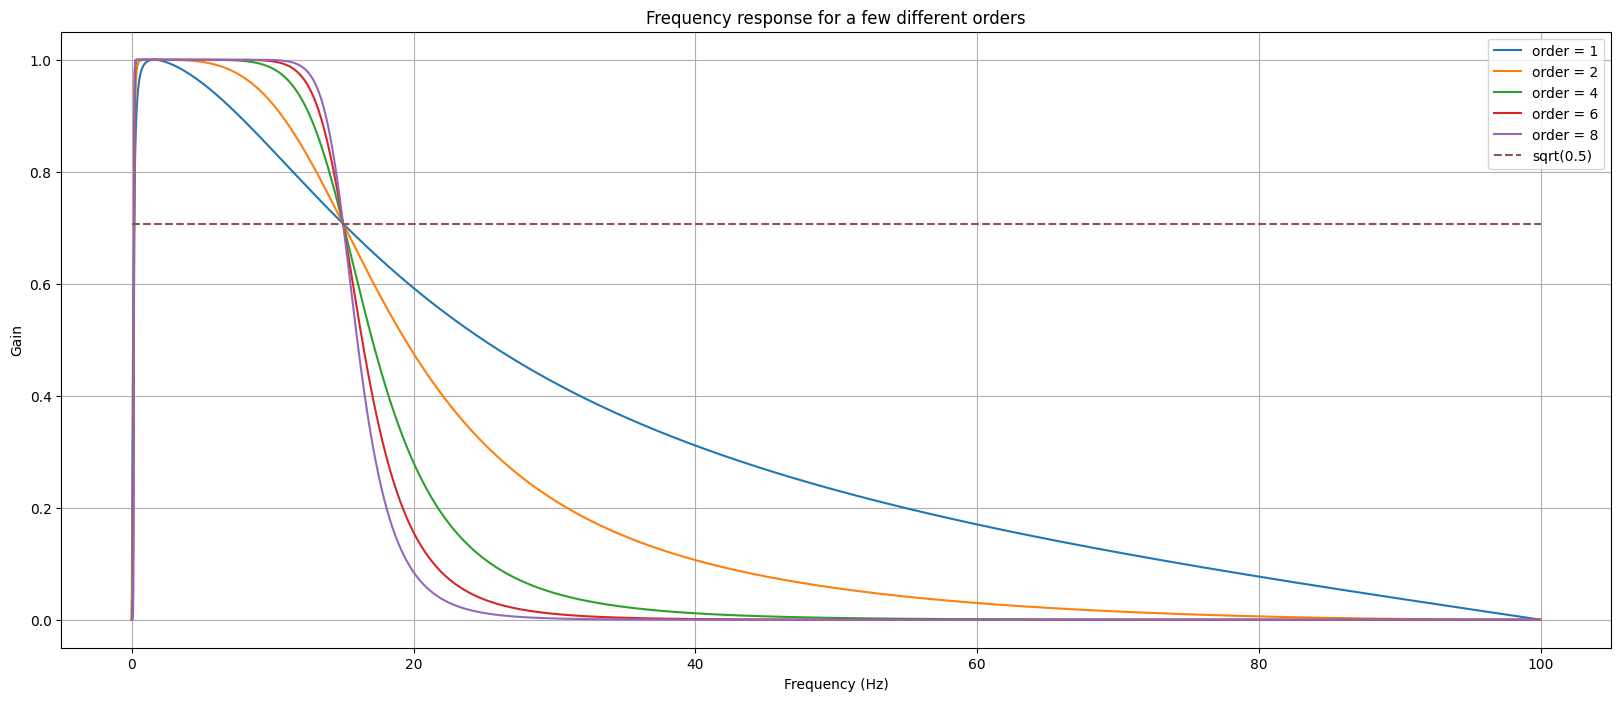

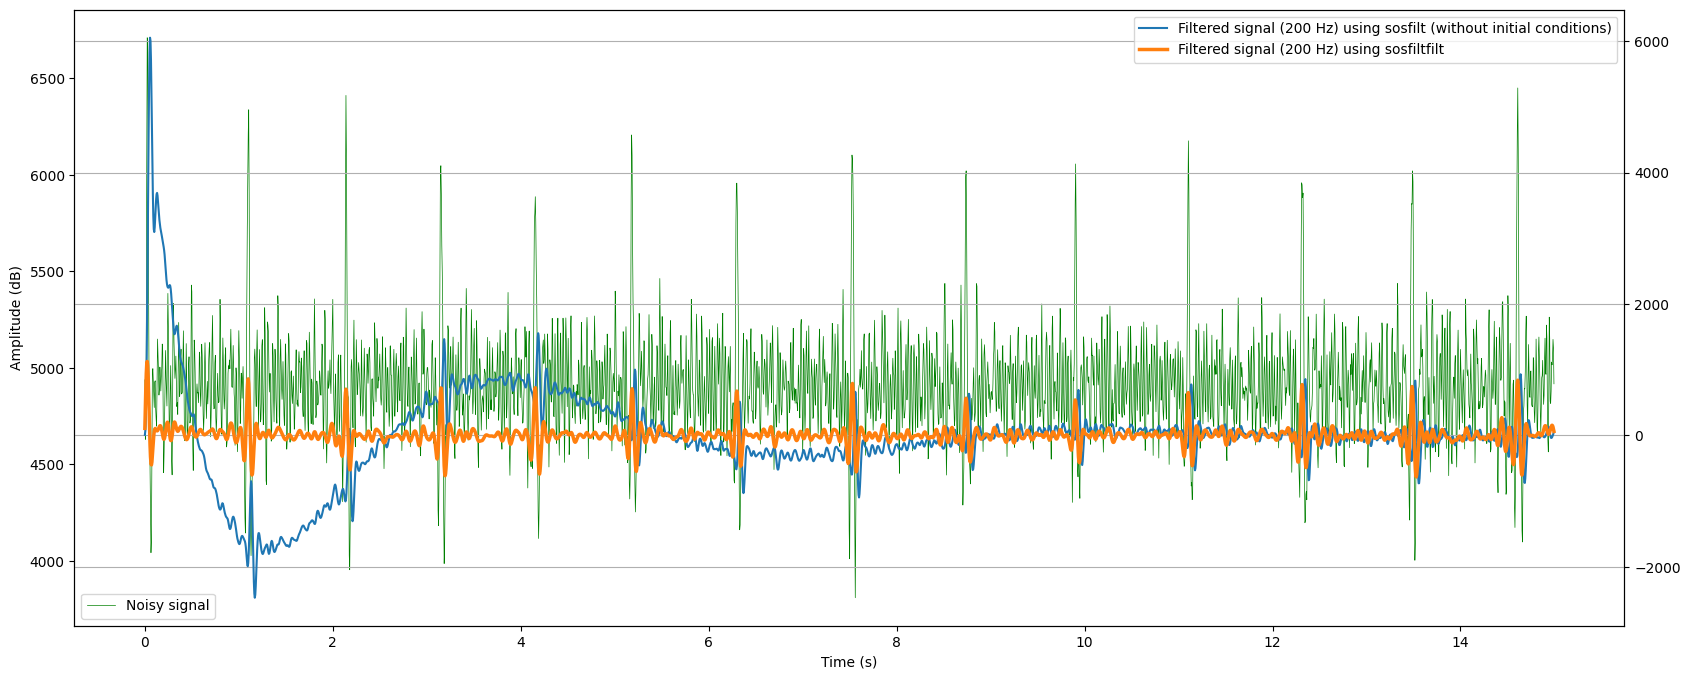

In [32]:
# Sample rate and desired cutoff frequencies (in Hz).
x = filtered
fs = 200  # corresponds to 60 beats per min (normal for human), assumed.
lowcut = 0.05 * 3.3  # 9.9 beats per min
highcut = 15  # 900 beats per min

# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         "--", label="sqrt(0.5)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.title("Frequency response for a few different orders")
plt.grid(True)
plt.legend(loc="best")

# Filter a noisy signal.


# Calculate time values in seconds
times = np.arange(x.shape[0], dtype='float') / fs

plt.figure(2, figsize=(20, 8))
plt.clf()
plt.ylabel("Amplitude (dB)")
plt.xlabel("Time (s)")
plt.plot(times, x, "g", linewidth=0.5, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times, butter_bandpass_filter(x, lowcut, highcut, fs, order=4),
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(times, y, linewidth=2.5, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)

# plt.twiny()
# plt.plot(butter_bandpass_forward_backward_filter(data, 0.05, 15, 250, order=4), linewidth=2, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)


plt.grid(True)
plt.axis("tight")
plt.legend(loc="upper right")

plt.show()


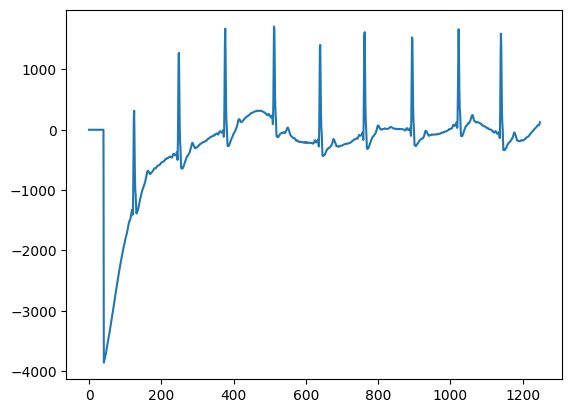

In [21]:
data = pd.read_csv('baseline_wander/raw_176708.csv').to_numpy()
plt.plot(data)

In [20]:
input_heartbeats = hp.remove_baseline_wander(np.copy(data), 128)
print(input_heartbeats)

ValueError: The length of the input vector x must be greater than padlen, which is 9.